In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import itertools

import sys
sys.path.append('../data/tecantaloupe/')

from growth.plate_spec import PlateSpec
from growth.plate_time_course_parser import SavageLabM1000Excel
from matplotlib import pyplot as plt

import seaborn as sns
from utils import *

matplotlib.rcParams.update({'font.size': 30})

In [2]:
def prepAndNormalize(ps,timecourse,cutoffTime):
    blanked = timecourse.blank(n_skip=0,n_av=3)
    smoothed = blanked.smooth()
    data = smoothed.data_for_label('OD600')
    yld = smoothed.GrowthYieldCutoff(cutoffTime,density_label='OD600')
    name2well = ps.name_to_well_mapping()

    yld = pd.DataFrame(yld, index=['yield']).T
    grouped_yld = yld.groupby(ps.well_to_name_mapping())
    mean_yield = grouped_yld.mean()
    
    normalized_yld = yld / mean_yield.loc['BW_sfGFP']
    normalized_mean_yld = normalized_yld.groupby(ps.well_to_name_mapping()).mean()
    normalized_std_yld = normalized_yld.groupby(ps.well_to_name_mapping()).std()
    return( (normalized_mean_yld,normalized_std_yld,grouped_yld) )

/usr/local/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)
../data/tecantaloupe/growth/plate_time_course_parser.py:80: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  return clipped_df.convert_objects(convert_numeric=True)


pval for comparison of CAF_Cholera1 and CAF_sfGFP is: 1.48E-07
pval for comparison of CAF_Anthrax2Gene1 and CAF_sfGFP is: 2.51E-07


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is dep

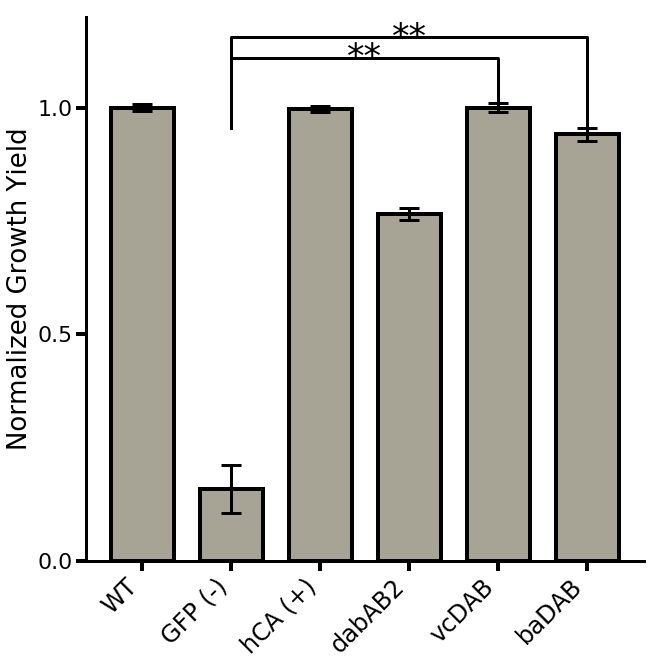

In [3]:
fig,ax = plt.subplots(figsize=(10,10))

# PlateSpec defined in CSV for easy editing
ps = PlateSpec.FromFile('../data/tecantaloupe/growth/plate_specs/2019_01_28_CAF_homologs.csv')

parser = SavageLabM1000Excel()
timecourse = parser.ParseFromFilename('../data/tecantaloupe/growth/data/2019_01_26_JJD_OD_overnight_homologs.xlsx')
normalized_mean_yld,normalized_std_yld,grouped_yld=prepAndNormalize(ps,timecourse,24)

#     print(data)
to_plot = [
    ('BW_sfGFP', 'WT'),
    ('CAF_sfGFP', 'GFP (-)'),
    ('CAF_HCA', 'hCA (+)'),
    ('CAF_DAB2', 'dabAB2'),
    ('CAF_Cholera1', 'vcDAB'),
    ('CAF_Anthrax2Gene1', 'baDAB'),
]

to_test = [
    ('CAF_Cholera1','CAF_sfGFP', 4,1),
    ('CAF_Anthrax2Gene1','CAF_sfGFP', 5,1),

    
    
#     ('CAF+pFE-DAB2_wt', 'CAF+pFE-NDH',5,3),
#     ('CAF+pFE-DAB2_wt', 'CAF+pFE-HCA2',5,2),
#     ('CAF+pFE-DAB2_wt', 'CAF+pFE-sfGFP',5,1),
]


labels = [name for label, name in to_plot]
ylds = [normalized_mean_yld.loc[t[0]][0] for t in to_plot]
stds = [normalized_std_yld.loc[t[0]][0] for t in to_plot]

xs = np.arange(len(ylds))
plt.bar(xs, ylds, yerr=stds, color=greyish, align='center', ecolor='k', width=0.7, edgecolor='k',
        linewidth=4, capsize=10, error_kw={'capsize': 10, 'capthick': 3, 'elinewidth': 3})

# print(grouped_yld)
i=0
for test1,test2,x1,x2 in to_test:
    i+=1
    y=max(ylds[x1]+stds[x1],0)#,ylds[x2]+stds[x2])
    h=i/10
#     print(grouped_yld.get_group(test[0])['yield'])
    tval,pval = ttest_ind(grouped_yld.get_group(test1)['yield'],grouped_yld.get_group(test2)['yield'])
    pval_corrected=pval*len(to_test)
#     print(pval)
    print('pval for comparison of %s and %s is: %.2E'%(test1,test2,pval_corrected))
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, color='k')
    
    sig_str=''
    va=''
    if (pval_corrected<0.0005):
        sig_str='**'
        va='center'
    elif (pval_corrected<0.05):
        sig_str='*'
        va='center'
    else:
        sig_str='n.s.'
        va='bottom'
    
    plt.text((x1+x2)*.5, y+h, sig_str, ha='center', va=va, color='k',fontsize=35)
    
    

plt.ylabel('Normalized Growth Yield', fontsize=26)

plt.xticks(xs, labels, rotation=45, fontsize=24, ha='right')
plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                length=10, width=4)
plt.yticks([0, 0.5, 1.0], fontsize=22)
plt.ylim(0.0, 1.2)
    # Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#     change axis weight
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
    
# plt.savefig('fig3/fig3B.eps',format='eps',bbox_inches='tight')
plt.show()

/usr/local/lib/python3.6/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)
../data/tecantaloupe/growth/plate_time_course_parser.py:80: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  return clipped_df.convert_objects(convert_numeric=True)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) inst

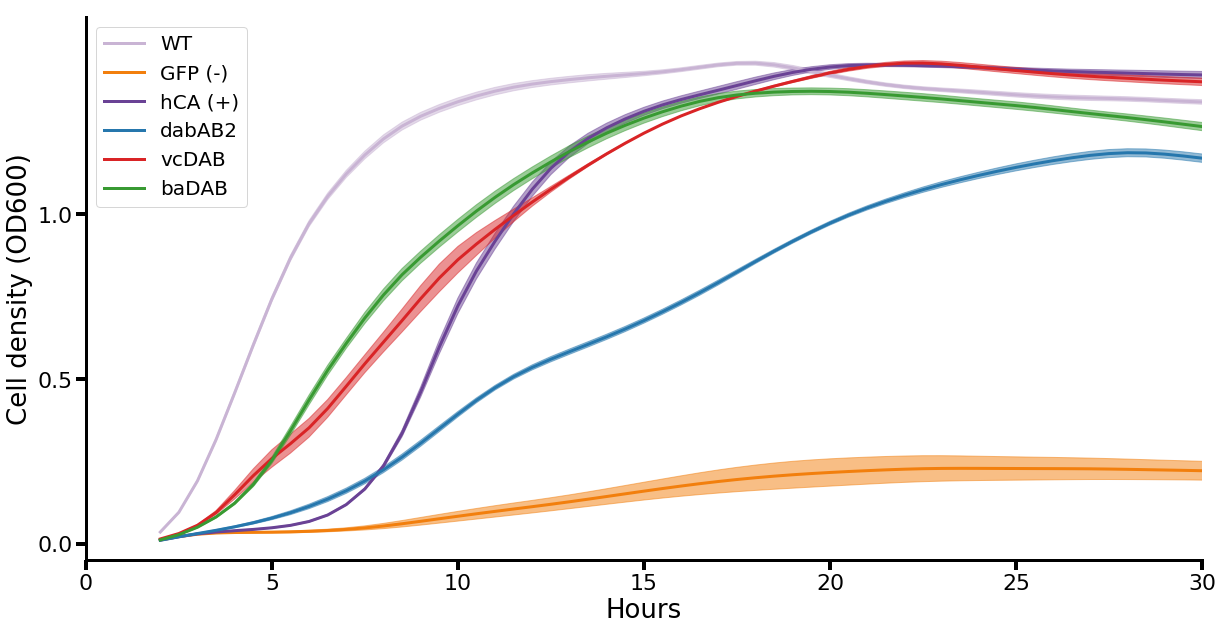

In [4]:
fig,ax = plt.subplots(figsize=(20,10))

# PlateSpec defined in CSV for easy editing
ps = PlateSpec.FromFile('../data/tecantaloupe/growth/plate_specs/2019_01_28_CAF_homologs.csv')


parser = SavageLabM1000Excel()
timecourse = parser.ParseFromFilename('../data/tecantaloupe/growth/data/2019_01_26_JJD_OD_overnight_homologs.xlsx')
blanked = timecourse.blank(n_skip=0,n_av=3)
smoothed = blanked.smooth()

means = smoothed.mean_by_name(ps)
sems = smoothed.sem_by_name(ps)

mean_OD = means.data_for_label('OD600')
sems_OD = sems.data_for_label('OD600')

time_h = mean_OD.time_s / (60.0*60.0)

#     print(data)
to_plot = [
    ('BW_sfGFP', 'WT'),
    ('CAF_sfGFP', 'GFP (-)'),
    ('CAF_HCA', 'hCA (+)'),
    ('CAF_DAB2', 'dabAB2'),
    ('CAF_Cholera1', 'vcDAB'),
    ('CAF_Anthrax2Gene1', 'baDAB'),
]

colors = {
    'WT':qual_palette[8],
    'GFP (-)':qual_palette[7],
    'hCA (+)':qual_palette[9],
    'dabAB2':qual_palette[1],
    'vcDAB':qual_palette[5],
    'baDAB':qual_palette[3],
}

labels = [name for label, name in to_plot]

for i, tp in enumerate(to_plot):
    c,label = tp
    color = colors[label]
    plt.fill_between(time_h, mean_OD[c] - sems_OD[c], mean_OD[c] + sems_OD[c],
                     color=color, alpha=0.5)
    plt.plot(time_h, mean_OD[c], label=label, color=color,lw=3)
    
plt.xlim(0,30)

plt.ylabel('Cell density (OD600)', fontsize=26)
plt.xlabel('Hours', fontsize=26)

# plt.xticks(xs, labels, rotation=45, fontsize=24, ha='right')
plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                length=10, width=4)
plt.yticks([0, 0.5, 1.0], fontsize=22)
plt.xticks(fontsize=22)
plt.ylim(-0.05, 1.6)
    # Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#     change axis weight
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
plt.legend(loc=0,fontsize=20)
    
# plt.savefig('fig3/fig3S2.eps',format='eps',bbox_inches='tight')
plt.show()

pval for comparison of CAF+Cholera and CAF+sfGFP is: 4.37E-03
pval for comparison of CAF+Anthrax2gene and CAF+sfGFP is: 1.84E-04


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is dep

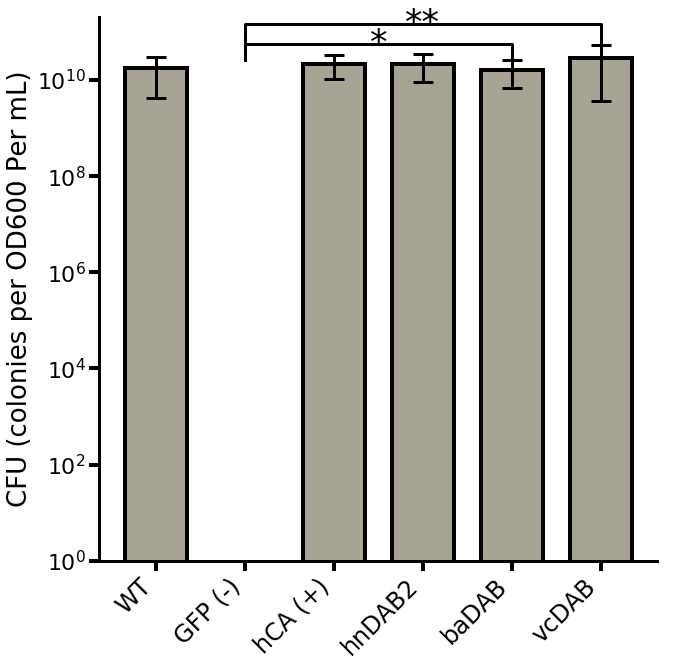

In [7]:
fig,ax = plt.subplots(figsize=(10,10))

inputFile = '../data/2019_02_08_pointMuants_and_Homologs_spotting/2019_02_08_pointMuants_and_Homologs_spotting.xlsx'
rawCounts = pd.read_excel(inputFile,sheet_name='ForAnalysis')
cols=rawCounts.columns
processedCounts = pd.DataFrame()
processedCounts['Strain']=rawCounts['Strain']
# processedCounts['replicate']=rawCounts['replicate']
for col in cols:
    if 'replicate' in col:
        rawCounts[col]=rawCounts[col].astype('float')
        if '(' in col:
            processedCounts[col.rsplit('(')[0]+'(CFU/OD*ml)'] = rawCounts[col]*5*1000/3
cols=rawCounts.columns
toMix = pd.DataFrame()
toMix['Strain']=rawCounts['Strain']
toMix['replicate']=rawCounts['replicate']
for col in cols:
    if 'replicate' in col:
        rawCounts[col]=rawCounts[col].astype('float')
        if '(' in col:
            toMix[col.rsplit('(')[0]+'(CFU/OD*ml)'] = rawCounts[col]*5*1000/3
mixed = toMix[toMix['replicate']==1].merge(toMix[toMix['replicate']>1],how='outer',on='Strain')
mixed=mixed.drop(['replicate_x','replicate_y'],axis=1)
aggregated = pd.DataFrame() 
aggregated['Strain'] = mixed['Strain'] 
aggregated['average'] = mixed.mean(axis=1)
# aggregated['average'] =aggregated['average']+1
aggregated['stdev'] = mixed.std(axis=1)
to_plot = [
    ('BW+sfGFP', 'WT'),
    ('CAF+sfGFP', 'GFP (-)'),
    ('CAF+HCA', 'hCA (+)'),
    ('CAF+DAB2wt', 'hnDAB2'),
    ('CAF+Anthrax2gene', 'baDAB'),
    ('CAF+Cholera', 'vcDAB'),
]

to_test = [
    ('CAF+Cholera','CAF+sfGFP', 4,1),
    ('CAF+Anthrax2gene','CAF+sfGFP', 5,1),

    
    
#     ('CAF+pFE-DAB2_wt', 'CAF+pFE-NDH',5,3),
#     ('CAF+pFE-DAB2_wt', 'CAF+pFE-HCA2',5,2),
#     ('CAF+pFE-DAB2_wt', 'CAF+pFE-sfGFP',5,1),
]

labels = [name for label, name in to_plot]
cfus = [aggregated[aggregated['Strain']==x[0]]['average'].values[0] for x in to_plot]
stds = [aggregated[aggregated['Strain']==x[0]]['stdev'].values[0] for x in to_plot]

xs = np.arange(len(cfus))
plt.bar(xs, cfus, yerr=stds, color=greyish, align='center', ecolor='k', width=0.7, edgecolor='k',
        linewidth=4, capsize=10, error_kw={'capsize': 10, 'capthick': 3, 'elinewidth': 3})


# print(grouped_yld)
i=1
for test1,test2,x1,x2 in to_test:
    y=max(cfus[x1]+stds[x1],0)#,ylds[x2]+stds[x2])
    h=i*3E10
    group1 = mixed[mixed['Strain']==test1].drop(['Strain'],axis=1).dropna(axis=1).values.ravel()
    group2 = mixed[mixed['Strain']==test2].drop(['Strain'],axis=1).dropna(axis=1).values.ravel()
#     print(grouped_yld.get_group(test[0])['yield'])
    tval,pval = ttest_ind(group1,group2,equal_var=False)
    pval_corrected=pval*len(to_test)
#     print(pval)
    print('pval for comparison of %s and %s is: %.2E'%(test1,test2,pval_corrected))
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, color='k')
    
    sig_str=''
    va=''
    if (pval_corrected<0.0005):
        sig_str='**'
        va='center'
    elif (pval_corrected<0.05):
        sig_str='*'
        va='center'
    else:
        sig_str='n.s.'
        va='bottom'
    
    plt.text((x1+x2)*.5, y+h, sig_str, ha='center', va=va, color='k',fontsize=35)
    i+=2
    
    

plt.ylabel('CFU (colonies per OD600 Per mL)', fontsize=26)

plt.xticks(xs, labels, rotation=45, fontsize=24, ha='right')
plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                length=10, width=4)
plt.yticks(fontsize=22)
plt.yscale('log')
plt.ylim((1, 20E10))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#     change axis weight
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
    
plt.savefig('fig5/fig5A.eps',format='eps',bbox_inches='tight')
plt.show()